# BIRDS

This is a small project utilizing the transformer architecture to generate new bird common names.

In [1]:
import csv
from matplotlib import pyplot as plt

with open('birds.csv', newline='') as f:
    reader = csv.reader(f)
    data = [n for _,n in list(reader)[1:]]

data_lower = list(map(str.lower, data))

chars = set()
for s in data_lower:
    chars = chars.union(s)
chars = sorted(list(chars))
chars_to_drop = set(list(chars[30:]) + ['.'])
data = list(filter(lambda n: not chars_to_drop.intersection(n), data_lower))

chars = ['#'] + list(sorted(set(chars).difference(chars_to_drop)))
vocab_size = len(chars)

ch2i = { ch:i for i,ch in enumerate(chars)}
i2ch = { i:ch for i,ch in enumerate(chars)}

print(f'{len(data)=}, {vocab_size=}')

len(data)=10817, vocab_size=30


In [2]:
import torch
from torch import nn
import torch.nn.functional as F

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# WAVENET

In [3]:
emd_dim = 4
hidden_dim = 68
layer_stack_height = 3
block_size = 2**layer_stack_height

In [4]:
def build_dataset(data):
    xs, ys = [], []

    for name in data:
        chrs = ['#']*block_size + list(name) + ['#']
        for ix in range(len(chrs)-block_size):
            xs.append([ch2i[ch] for ch in chrs[ix:ix+block_size]])
            ys.append(ch2i[chrs[ix+block_size]])

    X = torch.tensor(xs)
    Y = torch.tensor(ys)

    return X, Y

In [5]:
import random
random.seed(0)
random.shuffle(data)

n1 = int(len(data)*0.9)
n2 = int(len(data)*0.95)

X_train, Y_train = build_dataset(data[:n1])
X_valid, Y_valid = build_dataset(data[n1:n2])
X_test, Y_test = build_dataset(data[n2:])

X_total = torch.cat([X_train, X_valid, X_test])
Y_total = torch.cat([Y_train, Y_valid, Y_test])

In [6]:
n1, n2, len(data), len(X_train), len(X_valid), len(X_test)

(9735, 10276, 10817, 191515, 10650, 10624)

# Classes

In [7]:
g = torch.Generator().manual_seed(42)

In [8]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.bias = bias
        self.W = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
        self.b = torch.zeros(fan_out) if bias else None

    #     self.W = torch.empty(fan_in, fan_out)
    #     self.b = torch.empty(fan_out) if bias else None
    #     self.reset_parameters()

    # def reset_parameters(self):
    #     nn.init.kaiming_uniform_(self.W, a=self.fan_in**0.5, mode='fan_in', nonlinearity='tanh', generator=g)
    #     if self.bias:
    #         bound = 1 / self.fan_in**0.5
    #         nn.init.uniform_(self.b, -bound, bound, generator=g)
    
    def __call__(self, x):
        self.out = x @ self.W + self.b if self.bias else x @ self.W
        return self.out
    
    def parameters(self):
        return [self.W] + ([self.b] if self.bias else [])
    
    
class BatchNorm1d:

    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # buffers
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                mean = x.mean(0, keepdim=True)
                var = x.var(0, keepdim=True, unbiased=False)
            elif x.ndim == 3:
                mean = x.mean((0,1), keepdim=True)
                var = x.var((0,1) , keepdim=True, unbiased=False)
        else:
            mean = self.running_mean
            var = self.running_var
        x = (x - mean) / (var + self.eps).sqrt()
        self.out = self.gamma * x + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.W = torch.randn((num_embeddings, embedding_dim), generator=g) / (embedding_dim**0.5)
    
    def __call__(self, ix):
        self.out = self.W[ix]
        return self.out
    
    def parameters(self):
        return [self.W]
    
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, *layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [9]:
class Model:

    def __init__(self, vocab_size, emd_dim, hidden_dim):
        layers = [
            Embedding(vocab_size, emd_dim),
            FlattenConsecutive(2), Linear(emd_dim * 2, hidden_dim), BatchNorm1d(hidden_dim), Tanh()
            ]
        for _ in range(layer_stack_height-1):
            layers += [FlattenConsecutive(2), Linear(hidden_dim * 2, hidden_dim), BatchNorm1d(hidden_dim), Tanh()]
        layers += [Linear(hidden_dim, vocab_size), BatchNorm1d(vocab_size),]

        self.net = Sequential(*layers)

        with torch.no_grad():
            self.net.layers[-1].gamma *= .1
        for p in self.net.parameters():
            p.requires_grad = True

    def parameters(self):
        return [p for layer in self.net.layers for p in layer.parameters()]
    
    def predict(self, x):
        return self.net(x)
    
    def train(self, x, y, lr):
        # forward
        out = self.predict(x)
        loss = F.cross_entropy(out, y)
        # backward
        for p in self.parameters():
            p.grad = None
        loss.backward()
        # update: sgd
        with torch.no_grad():
            for p in self.parameters():
                p -= p.grad * lr
        return loss
    
    def switch_mode(self, mode=True):
        for layer in self.net.layers:
            if isinstance(layer, BatchNorm1d):
                layer.training = mode

In [10]:
MLP = Model(vocab_size, emd_dim, hidden_dim)
parameters = MLP.parameters()

print(f'Number of parameters: {sum(p.numel() for p in parameters)}')

Number of parameters: 21902


In [11]:
MLP.predict(X_train[:10])
for layer in MLP.net.layers:
    print(layer.__class__.__name__, tuple(layer.out.shape))

Embedding (10, 8, 4)
FlattenConsecutive (10, 4, 8)
Linear (10, 4, 68)
BatchNorm1d (10, 4, 68)
Tanh (10, 4, 68)
FlattenConsecutive (10, 2, 136)
Linear (10, 2, 68)
BatchNorm1d (10, 2, 68)
Tanh (10, 2, 68)
FlattenConsecutive (10, 136)
Linear (10, 68)
BatchNorm1d (10, 68)
Tanh (10, 68)
Linear (10, 30)
BatchNorm1d (10, 30)


In [12]:
steps = 100000
lr = .1
batch_size = 64
print(f'Expected loss at initialization: {-torch.tensor(1/vocab_size).log().item():.4f}')

Expected loss at initialization: 3.4012


In [13]:
lossi = []
lossi_valid = []
loglossi = []
ud = []

for i in range(steps):

    if (i%(steps//2)) == 0 and i > 0:
        lr /= 10

    ixs = torch.randint(0, X_train.size()[0], (batch_size,))
    loss = MLP.train(X_train[ixs], Y_train[ixs], lr)
    
    lossi.append(loss.item())
    if i % (steps//500) == 0:
        MLP.switch_mode(False)
        with torch.no_grad():
            lossi_valid.append(F.cross_entropy(MLP.predict(X_valid), Y_valid).item())
        MLP.switch_mode(True)
    loglossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in MLP.parameters()])

    if i % (steps//10) == 0:
        print(f'{i=}, {lossi[i]=}')

i=0, lossi[i]=3.390450954437256
i=10000, lossi[i]=1.479749083518982
i=20000, lossi[i]=0.9829525947570801
i=30000, lossi[i]=1.4581764936447144
i=40000, lossi[i]=1.444273829460144
i=50000, lossi[i]=1.2635616064071655
i=60000, lossi[i]=1.5664424896240234
i=70000, lossi[i]=1.1568715572357178
i=80000, lossi[i]=1.1438685655593872
i=90000, lossi[i]=0.990890383720398


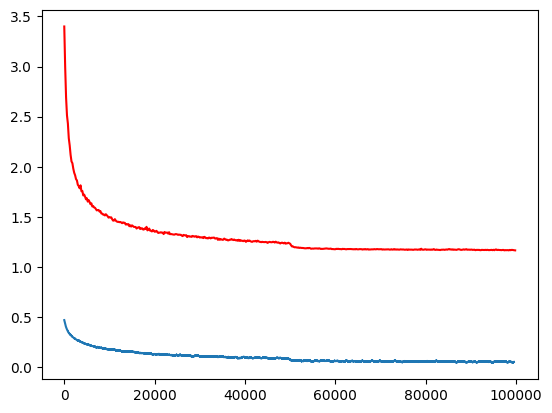

In [14]:
roll = 500
rolling_loss = [sum(loglossi[i:i+roll])/roll for i in range(len(lossi)-roll)]

fig = plt.figure()
plt.plot(rolling_loss)
plt.plot(range(0,len(rolling_loss)+2*steps//500, steps//500), lossi_valid, 'r')

layer i=2 (Linear), t.mean()= 0.05, t.std()=1.87, % saturated: 57.00
layer i=6 (Linear), t.mean()=-0.10, t.std()=2.67, % saturated: 70.07
layer i=10 (Linear), t.mean()=-0.08, t.std()=2.70, % saturated: 75.21
layer i=13 (Linear), t.mean()= 0.13, t.std()=2.66, % saturated: 68.23


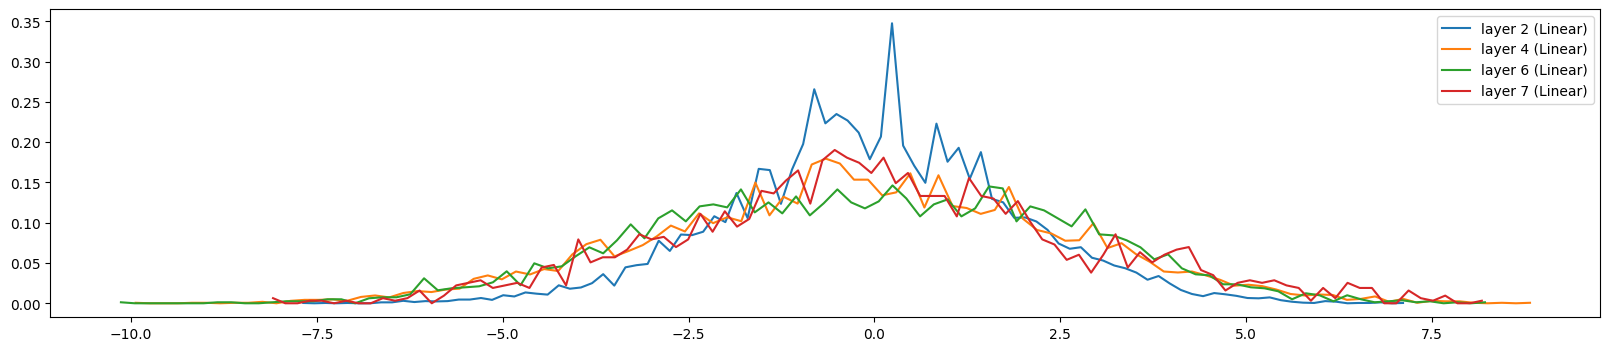

In [15]:
plt.figure(figsize=(20,4))
lengeds = []
for i,layer in enumerate(MLP.net.layers):
    if isinstance(layer, Linear):
        t = layer.out
        print(f'layer {i=} ({layer.__class__.__name__}), {t.mean()=: 2.2f}, {t.std()=:.2f}, % saturated: {((t.abs()>.99).sum().float()/t.numel()*100).item():.2f}')
        hy, hx = torch.histogram(t, density=True, bins=100)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        lengeds.append(f'layer {i//2+1} ({layer.__class__.__name__})')
plt.legend(lengeds)

(torch.Size([30, 4])   ), mean=-1.7385e-09, std=4.2869e-02, grad/data=3.5438e-02
(torch.Size([8, 68])   ), mean=+3.5644e-04, std=2.7692e-02, grad/data=3.9126e-02
(torch.Size([136, 68]) ), mean=-1.1266e-04, std=1.3022e-02, grad/data=4.2931e-02
(torch.Size([136, 68]) ), mean=-2.4277e-05, std=1.0955e-02, grad/data=4.2877e-02
(torch.Size([68, 30])  ), mean=+1.3371e-04, std=1.3449e-02, grad/data=3.2666e-02


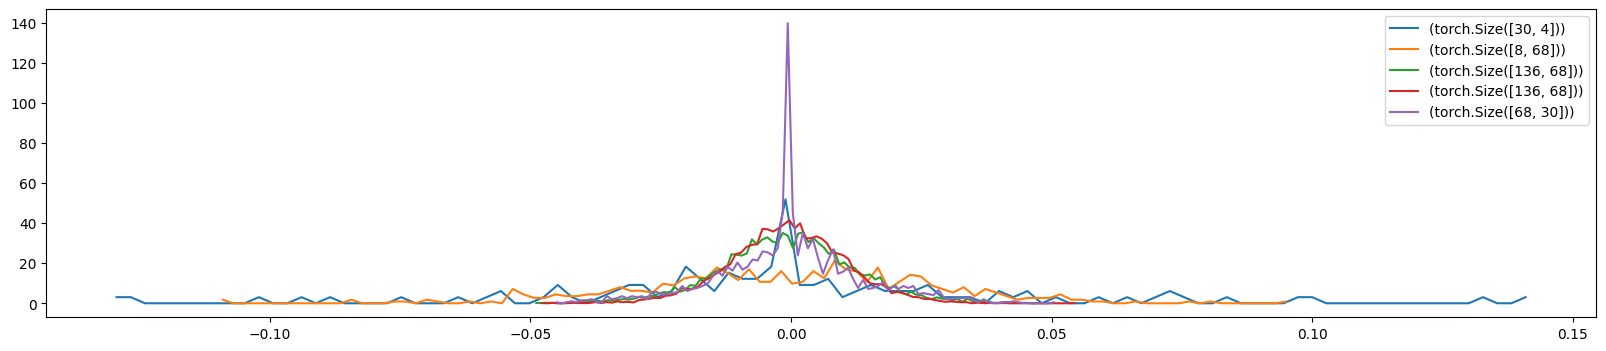

In [16]:
plt.figure(figsize=(20,4))
lengeds = []
for i,p in enumerate(MLP.parameters()):
    if p.ndim == 2:
        t = p.grad
        print(f'({str(p.shape):22s}), mean={t.mean():+.4e}, std={t.std():.4e}, grad/data={t.abs().mean()/p.abs().mean():.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        lengeds.append(f'({p.shape})')
plt.legend(lengeds)

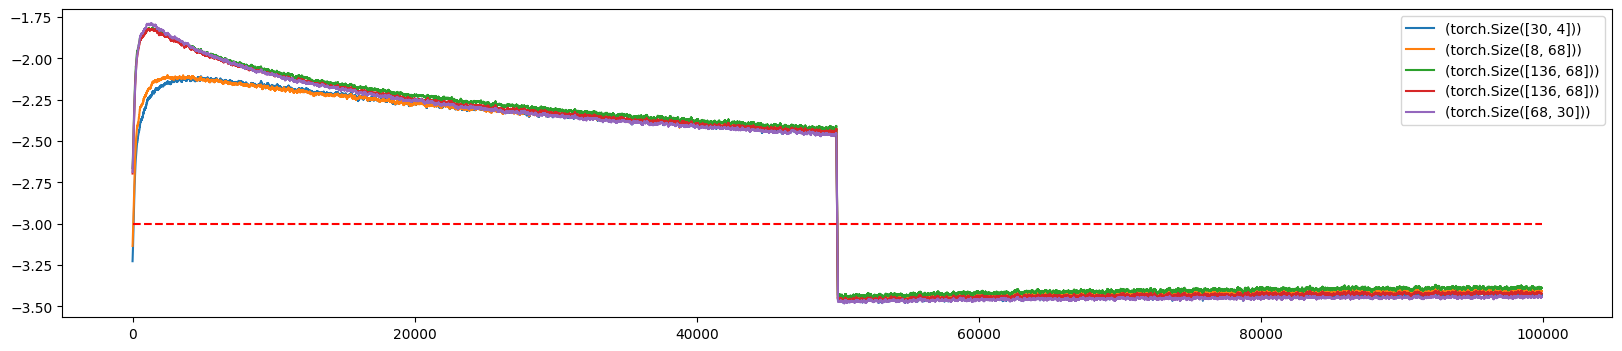

In [17]:
roll = 100
plt.figure(figsize=(20,4))
lengeds = []
for l,p in enumerate(MLP.parameters()):
    if p.ndim == 2:
        plt.plot([sum([ud[k][l] for k in range(i,i+roll)])/roll for i in range(len(ud)-roll)])
        lengeds.append(f'({p.shape})')
plt.plot([0, len(ud)-roll], [-3,-3], 'r--')
plt.legend(lengeds)

In [18]:
MLP.switch_mode(False)

def compute_loss(X, Y):
    Y_pred = MLP.predict(X)
    loss = F.cross_entropy(Y_pred, Y)
    print(f'{loss.item()=}')

compute_loss(X_train, Y_train)
compute_loss(torch.concat((X_valid, X_test)), torch.concat((Y_valid, Y_test)))

loss.item()=1.0520044565200806
loss.item()=1.155165433883667


with block=20, emd_dim=4, hidden_dim=100, n_hidden_layers=4:
loss.item()=0.9029964208602905
loss.item()=1.0322859287261963

with block=8, emd_dim=4, hidden_dim=100, n_hidden_layers=4:
loss.item()=0.9119027853012085
loss.item()=1.0441724061965942

block_size = 8, emd_dim = 4, hidden_dim = 30, n_hidden_layers = 8
loss.item()=1.3387105464935303
loss.item()=1.3823189735412598

In [19]:
temperature = 1.

# g = torch.Generator().manual_seed(0)
for _ in range(20):
    context = [ch2i['#']] * block_size
    while True:
        # forward pass
        Xc = torch.tensor(context).unsqueeze(0)
        logits = MLP.predict(Xc)
        logits = logits / temperature
        probs = F.softmax(logits, dim=1)

        next_ch = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [next_ch]
        if next_ch == ch2i['#']:
            print()
            break
        print(i2ch[next_ch], end='')

common buttong
gondian spowre warbler
lesser tailorbird
short-billed honeyeater
viomeri's tingfisher
solitan
black-fantail
royst-breasted tapaculo
whileater's puffan albornbill
urkindana hawk
philippine manakin
chilibill
rosy manniar striped parkted forebanted imperial pighweater
cinombo hapkarrot
red-vented mountain ureenbul
white-ringed oaile-crowned sparrow-cwcrenal warbler
black-faced warbler
srighbird
streak-breasted brushfinch
golden-tailed mafsean
